In [1]:
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from analysis_utils import d_prime
from scipy.stats import norm
import seaborn as sns

os.chdir('../')
wd = os.getcwd()
wd

In [ ]:
fnames[0].split('/')[-1].split('_')[-2][-1]

In [43]:
fnames = glob.glob(f'{wd}/logs/sub-001/ses-2/sub-001_ses-2_task-yesno*/*.tsv')

all_logs = pd.DataFrame([])
summ = pd.DataFrame(columns=['run', 'attn_sz', 'dprime', 'criterion'])
summary = pd.DataFrame([]) 

for f in fnames:

    attn = f.split('/')[-1].split('_')[2][-1].lower()
    run = f.split('/')[-1].split('_')[-2][-1]
    df = pd.read_table(f,keep_default_na=True)
    df = df.drop(df[(df.phase % 2 == 1) & (df.event_type == 'stim')].index.append(df[df.event_type == 'pulse'].index))
    df['duration'] = df['duration'].fillna(0)
    df['nr_frames'] = df['nr_frames'].fillna(0)
    df['end'] = df.onset + df.duration
    df['end_abs'] = df.onset_abs + df.duration
    df['attn_size'] = attn
    df['run'] = run

    baseline = 0.5
    duration = 0.75
    sizes = ['large_prop','small_prop']
    
    for sz in sizes:
        on_task = True if attn == sz[0] else False
        stim_df = df[df.event_type == 'stim']
        switch_loc = np.diff(stim_df[sz], prepend=baseline) != 0
        switch_loc = stim_df[(switch_loc) & (stim_df[sz] != baseline)].index  # drop values where color_balance is 0.5
        responses = df.loc[df.response == 'b']

        tp = sum([(abs(i - responses.onset) < duration).any() \
                          for i in stim_df.loc[switch_loc].end])  # true positives
        fn = len(switch_loc) - tp  # false negatives (missed switches)
        fp = len(responses) - tp  # false positives (responded with no switch)
        tn = len(stim_df) - len(switch_loc) - fn  # true negative

        d, c = d_prime(tp, fn, fp, tn)
        
        summary = summary.append({'run': run,
                              'attn_sz': sz[0],
                              'on_task': bool(on_task),
                              'dprime': d,
                              'criterion': c},
                              ignore_index=True
                             )
summary

,attn_sz,criterion,dprime,on_task,run
0,l,0.935463,3.002823,1.0,5
1,s,0.934448,0.736999,0.0,5
2,l,1.143447,0.783990,0.0,1
3,s,1.173124,2.106952,1.0,1
4,l,1.014806,2.826029,1.0,4
5,s,0.947746,0.901092,0.0,4
6,l,1.342578,3.353910,1.0,3
7,s,1.008375,0.884852,0.0,3
8,l,1.279438,3.486292,1.0,2
9,s,1.043075,0.502873,0.0,2


In [48]:
summary['on_task'] = summary['on_task'].astype(bool)

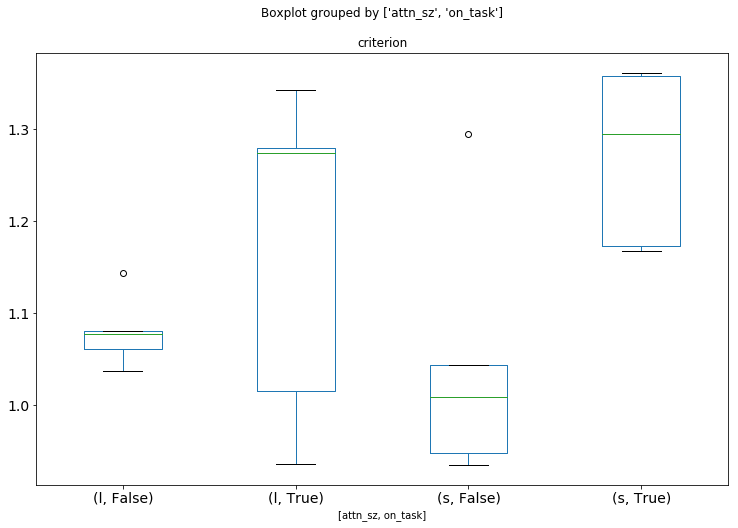

In [49]:
summary.boxplot(column='criterion', by=['attn_sz','on_task'], grid=False,figsize=(12,8), fontsize=14)

# plt.scatter(x,[s_df.criterion,l_df.criterion])
# plt.savefig('criterion_boxplot.png', dpi=300)

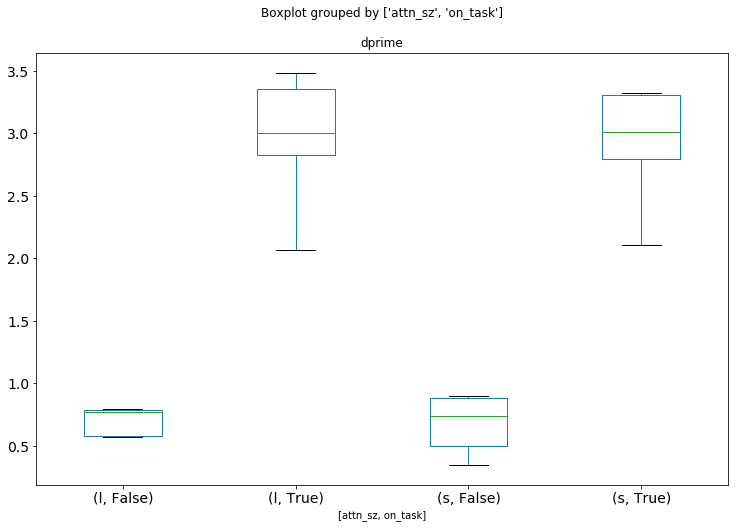

In [50]:
# s_df = summary[summary.attn_sz == 'l']
# l_df = summary[summary.attn_sz == 's']
# x = np.ones(len(s_df))*1
# x = np.append(x,np.ones(len(l_df))*2)

summary.boxplot(column=['dprime'], by=['attn_sz','on_task'], grid=False,figsize=(12,8), fontsize=14)

# plt.scatter(x,[s_df.dprime,l_df.dprime])
# plt.savefig('criterion_boxplot.png', dpi=300)

In [62]:
summary

,attn_sz,criterion,dprime,on_task,run
2,l,1.143447,0.783990,False,1
3,s,1.173124,2.106952,True,1
13,s,1.294948,0.346096,False,1
12,l,1.274040,2.065999,True,1
9,s,1.043075,0.502873,False,2
17,s,1.361578,3.305070,True,2
16,l,1.080343,0.577409,False,2
8,l,1.279438,3.486292,True,2
18,l,1.060634,0.772288,False,3
19,s,1.295046,3.010948,True,3


In [58]:
summary = summary.sort_values(by='run')

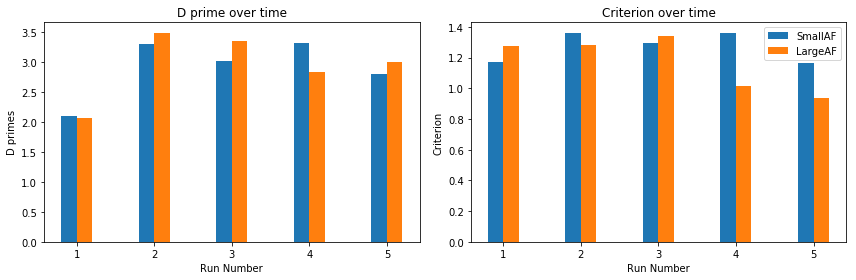

In [69]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

labels = summary.run.unique()

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

rects1 = ax[0].bar(x - width/2, summary[(summary.attn_sz == 's') & summary.on_task].dprime, width, label='SmallAF')
rects2 = ax[0].bar(x + width/2, summary[(summary.attn_sz == 'l') & summary.on_task].dprime, width, label='LargeAF')

ax[0].set_ylabel('D primes')
ax[0].set_xlabel('Run Number')
ax[0].set_title('D prime over time')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
# ax[0].legend()

rects1 = ax[1].bar(x - width/2, summary[(summary.attn_sz == 's') & summary.on_task].criterion, width, label='SmallAF')
rects2 = ax[1].bar(x + width/2, summary[(summary.attn_sz == 'l') & summary.on_task].criterion, width, label='LargeAF')

ax[1].set_ylabel('Criterion')
ax[1].set_xlabel('Run Number')
ax[1].set_title('Criterion over time')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend(loc='best')

fig.tight_layout()

plt.show()